In [2]:
!pip install pyngrok

!ngrok config add-authtoken 2srdtdH3ifRy4Gw48m0YvvdtCZc_3eQHsE1BM6ABPpb1KbMbx

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [3]:
!pip install twilio python-dotenv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.0 MB/s eta 0:00:00


## Importing the Dependencies

In [4]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_absolute_percentage_error,r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from flask import Flask, request, render_template, jsonify
from dotenv import load_dotenv
from twilio.rest import Client
from pyngrok import ngrok
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

## Data Collection and Data Preprossessing

In [5]:
#loading the dataset to a pandas DataFrame
weather_data = pd.read_csv('/content/Data_augmented_50.csv')
weather_data.head()

,datetime,temp,humidity,rainfall,windspeed,FLOOD
0,2022-01-01,7.2,70.6,0.00,4.0,0
1,2022-01-02,8.2,66.9,0.00,5.1,0
2,2022-01-03,8.6,67.6,0.00,3.6,0
3,2022-01-04,8.8,71.8,29.17,5.4,0
4,2022-01-05,8.4,89.6,45.83,4.3,0


## Initial Exploration and Data cleaning (Data Wrangling)

In [6]:
# Information about dataset
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103 entries, 0 to 1102
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   1103 non-null   object 
 1   temp       1103 non-null   float64
 2   humidity   1103 non-null   float64
 3   rainfall   1103 non-null   float64
 4   windspeed  1103 non-null   float64
 5   FLOOD      1103 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 51.8+ KB


In [7]:
print('Missing Values in Each Column:\n', weather_data.isnull().sum())

Missing Values in Each Column:
 datetime     0
temp         0
humidity     0
rainfall     0
windspeed    0
FLOOD        0
dtype: int64


In [8]:
# Checking duplicate values
weather_data.duplicated().sum()

np.int64(391)

In [9]:
weather_data.shape

(1103, 6)

In [10]:
weather_data.columns

Index(['datetime', 'temp', 'humidity', 'rainfall', 'windspeed', 'FLOOD'], dtype='object')

# Exploraory Data Analysis

# Univariate Analysis

### Histograms (Distribution Plots)

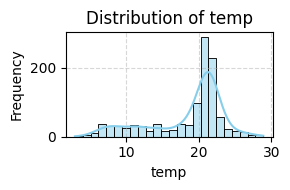

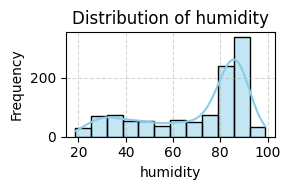

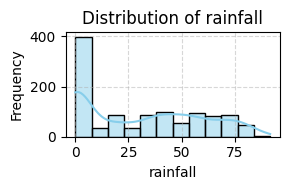

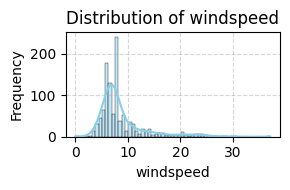

In [11]:
# Plot histograms for numeric features
numeric_cols = ['temp', 'humidity', 'rainfall', 'windspeed']

for col in numeric_cols:
    plt.figure(figsize=(3, 2))
    sns.histplot(weather_data[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


### Boxplots (Detecting Outliers)

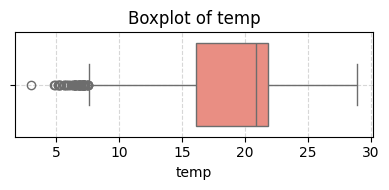

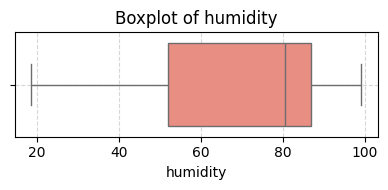

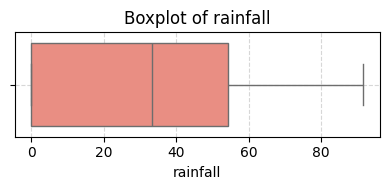

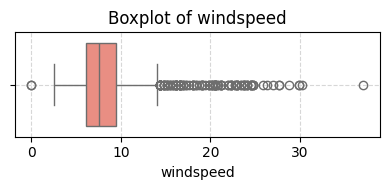

In [12]:
# Boxplot for each feature
for col in numeric_cols:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=weather_data[col], color='salmon')
    plt.title(f'Boxplot of {col}')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


### Bar Plot for Target Variable (FLOOD)

<ipython-input-13-2495860209>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='FLOOD', data=weather_data, palette='Set1')


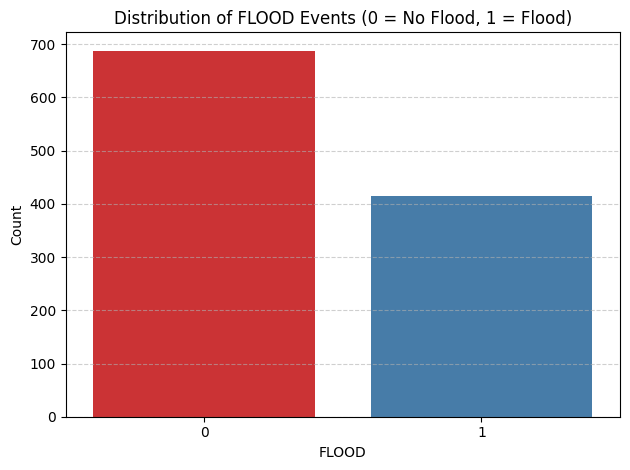

<Figure size 300x200 with 0 Axes>

In [13]:
# Count plot for the target variable
sns.countplot(x='FLOOD', data=weather_data, palette='Set1')
plt.title("Distribution of FLOOD Events (0 = No Flood, 1 = Flood)")
plt.xlabel("FLOOD")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.figure(figsize=(3, 2))
plt.show()


## Numerical Features vs. Target (FLOOD)

### Boxplots: Feature Distributions by Class (FLOOD)

<ipython-input-14-3430612001>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FLOOD', y=col, data=weather_data, palette='Set2')


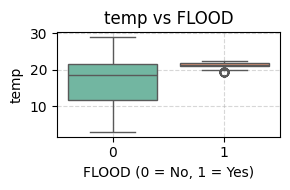

<ipython-input-14-3430612001>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FLOOD', y=col, data=weather_data, palette='Set2')


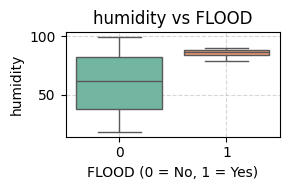

<ipython-input-14-3430612001>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FLOOD', y=col, data=weather_data, palette='Set2')


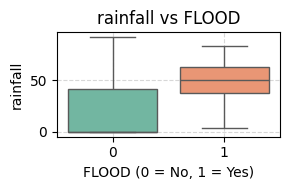

<ipython-input-14-3430612001>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='FLOOD', y=col, data=weather_data, palette='Set2')


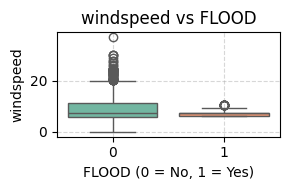

In [14]:
features = ['temp', 'humidity', 'rainfall', 'windspeed']

for col in features:
    plt.figure(figsize=(3, 2))
    sns.boxplot(x='FLOOD', y=col, data=weather_data, palette='Set2')
    plt.title(f'{col} vs FLOOD')
    plt.xlabel('FLOOD (0 = No, 1 = Yes)')
    plt.ylabel(col)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


### Correlation Heatmap (Numeric Features)

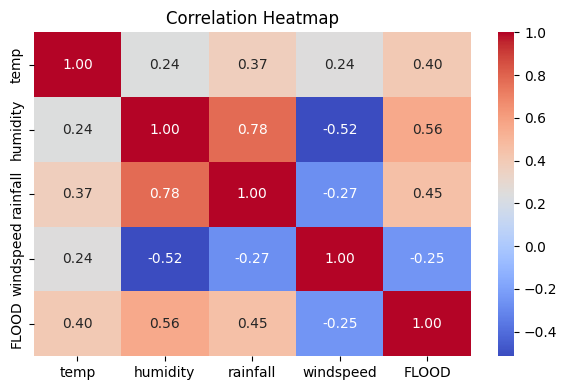

In [15]:
# Compute correlation matrix
corr = weather_data.drop(columns=['datetime']).corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


### Pairplot (Visual Bivariate Relationships)

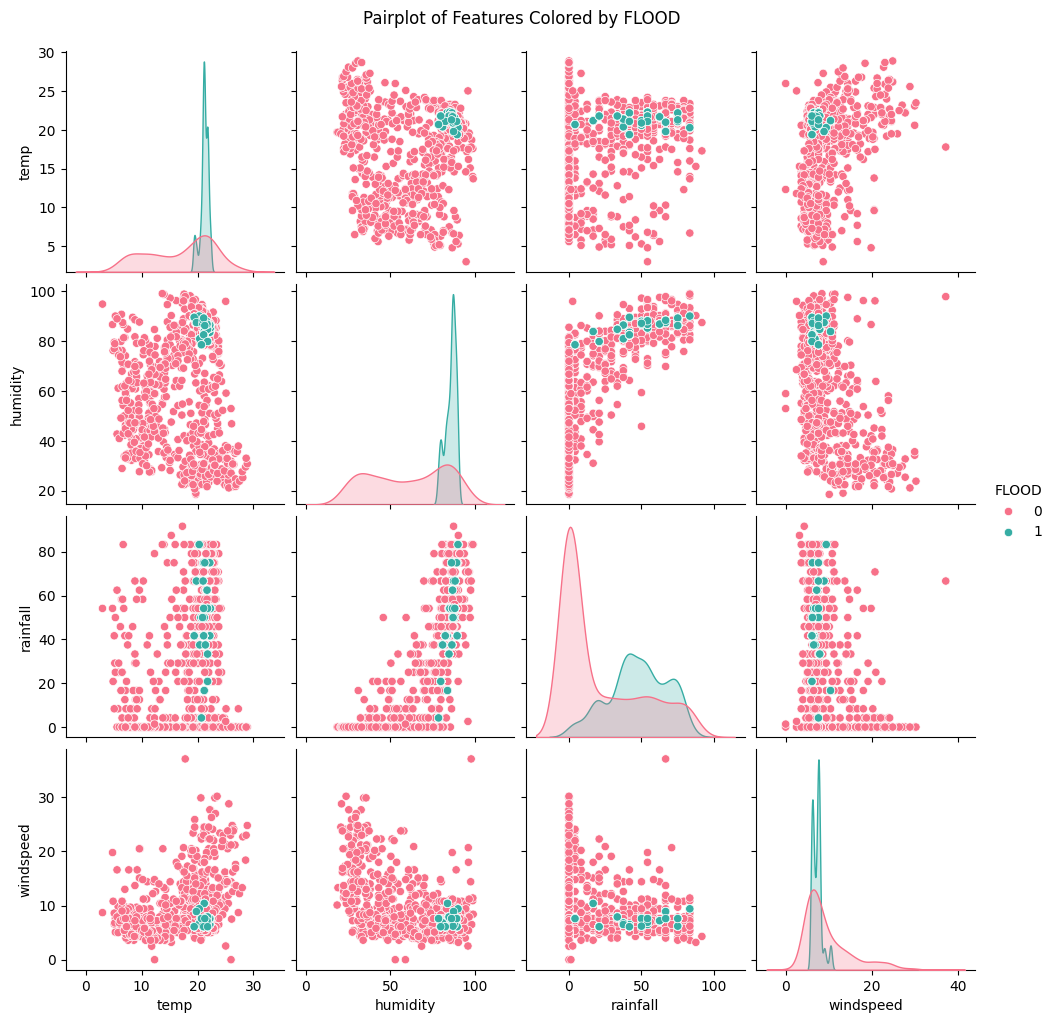

In [16]:
sns.pairplot(weather_data, hue="FLOOD", vars=features, palette="husl", diag_kind='kde')
plt.suptitle("Pairplot of Features Colored by FLOOD", y=1.02)
plt.show()


### Line Plot of Rainfall Over Time (Optional Time Insight)

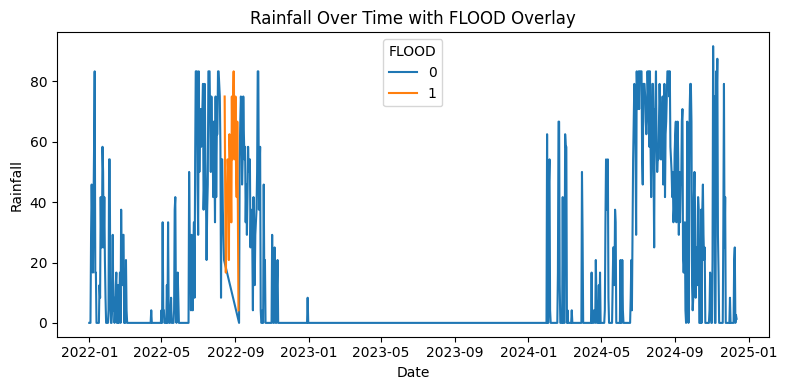

In [17]:
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])
plt.figure(figsize=(8, 4))
sns.lineplot(x='datetime', y='rainfall', data=weather_data, hue='FLOOD', palette='tab10')
plt.title('Rainfall Over Time with FLOOD Overlay')
plt.xlabel('Date')
plt.ylabel('Rainfall')
plt.tight_layout()
plt.show()


### Bivariate Scatter Plots: Feature Pairs Colored by FLOOD

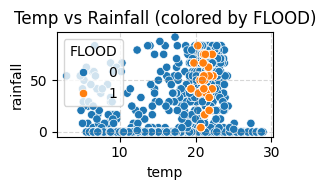

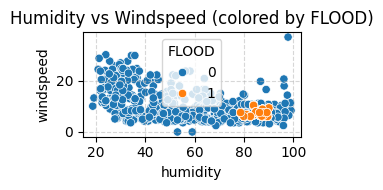

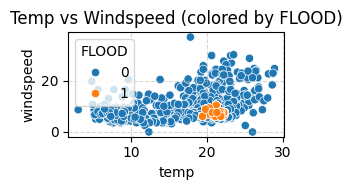

In [18]:
scatter_pairs = [
    ('temp', 'rainfall'),
    ('humidity', 'windspeed'),
    ('temp', 'windspeed')
]

for x_col, y_col in scatter_pairs:
    plt.figure(figsize=(3, 2))
    sns.scatterplot(data=weather_data, x=x_col, y=y_col, hue='FLOOD', c ="blue")
    plt.title(f'{x_col.capitalize()} vs {y_col.capitalize()} (colored by FLOOD)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


### Exploraory Data Analysis

In [19]:
weather_data.sample(n=7)

,datetime,temp,humidity,rainfall,windspeed,FLOOD
659,2024-10-21,15.9,61.8,0.00,5.4,0
193,2022-07-13,23.0,80.0,54.17,8.6,0
793,2022-09-05,20.4,81.0,37.50,6.8,1
972,2022-08-22,21.7,86.9,62.50,7.2,1
233,2022-08-22,21.7,86.9,62.50,7.2,1
971,2022-08-28,21.1,89.3,75.00,7.6,1
459,2024-04-04,19.0,30.4,0.00,10.8,0


In [20]:
# Summary of Data
weather_data.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,1103,2023-03-05 02:47:06.473254656,2022-01-01 00:00:00,2022-08-16 00:00:00,2022-09-01 00:00:00,2024-03-11 12:00:00,2024-12-12 00:00:00,NaN
temp,1103.0,18.510771,3.0,16.1,20.9,21.8,28.9,5.13426
humidity,1103.0,69.937883,18.6,51.95,80.4,86.9,99.1,21.807094
rainfall,1103.0,30.977961,0.0,0.0,33.33,54.17,91.67,28.182949
windspeed,1103.0,8.708802,0.0,6.1,7.6,9.4,37.1,4.534746
FLOOD,1103.0,0.376247,0.0,0.0,0.0,1.0,1.0,0.484663


In [21]:
#separating data and labels
X = weather_data.drop(columns =["datetime","FLOOD" ])
Y = weather_data["FLOOD"]

In [22]:
print(X)
print(Y)

      temp  humidity  rainfall  windspeed
0      7.2      70.6      0.00        4.0
1      8.2      66.9      0.00        5.1
2      8.6      67.6      0.00        3.6
3      8.8      71.8     29.17        5.4
4      8.4      89.6     45.83        4.3
...    ...       ...       ...        ...
1098  21.1      82.6     41.67        6.1
1099  21.8      79.9     20.83        6.1
1100  20.7      78.6      4.17        7.6
1101  20.7      78.6      4.17        7.6
1102  21.3      86.3     75.00        7.6

[1103 rows x 4 columns]
0       0
1       0
2       0
3       0
4       0
       ..
1098    1
1099    1
1100    1
1101    1
1102    1
Name: FLOOD, Length: 1103, dtype: int64


### Missing value Treatment

In [23]:
# Removing the null values in the target variable as the flood score is only available
weather_data = weather_data.dropna()
weather_data.isnull().sum()

,0
datetime,0
temp,0
humidity,0
rainfall,0
windspeed,0
FLOOD,0


In [24]:
weather_data.dtypes

,0
datetime,datetime64[ns]
temp,float64
humidity,float64
rainfall,float64
windspeed,float64
FLOOD,int64


In [25]:
weather_data.nunique()

,0
datetime,712
temp,212
humidity,450
rainfall,26
windspeed,94
FLOOD,2


### Correlation between independent variables for Feature Selection

In [26]:
weather_data=weather_data.drop(columns =["datetime"])

In [27]:
column_list = list(weather_data.columns)
column_list

['temp', 'humidity', 'rainfall', 'windspeed', 'FLOOD']

In [28]:
correlation_plot = weather_data.corr()
correlation_plot.style.background_gradient(cmap = 'RdYlGn')

,temp,humidity,rainfall,windspeed,FLOOD
temp,1.000000,0.239093,0.370845,0.242707,0.402389
humidity,0.239093,1.000000,0.776704,-0.515902,0.558608
rainfall,0.370845,0.776704,1.000000,-0.273689,0.451946
windspeed,0.242707,-0.515902,-0.273689,1.000000,-0.251302
FLOOD,0.402389,0.558608,0.451946,-0.251302,1.000000


## Visual Representation of DataSet

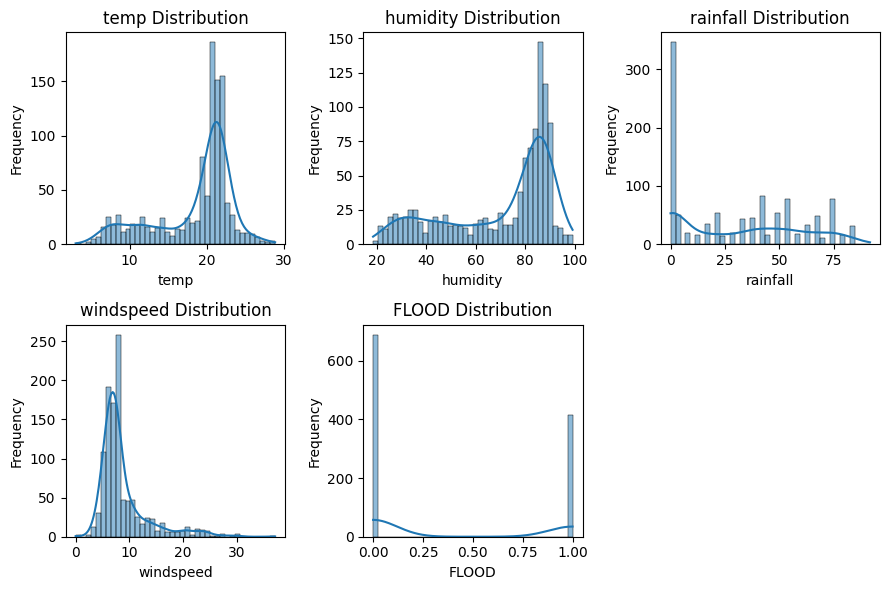

In [29]:
# Define number of rows and columns for the grid
nrows = (len(weather_data.columns) + 2) // 3  # 3 graphs per row
ncols = min(len(weather_data.columns), 3)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 3 * nrows))

# Flatten axes if necessary
if nrows == 1:
    axes = [axes]

# Plot distribution for each feature
for i, col in enumerate(weather_data.columns):
    row_index = i // ncols
    col_index = i % ncols
    ax = axes[row_index][col_index]
    sns.histplot(weather_data[col],bins=40, kde=True, ax=ax)
    ax.set_title(col + ' Distribution')
    ax.set_ylabel('Frequency')
    ax.set_xlabel(col)

# Remove empty subplots if ncols * nrows > number of features
if nrows * ncols > len(weather_data.columns):
    for i in range(len(weather_data.columns), nrows * ncols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show();

## Features VS Target

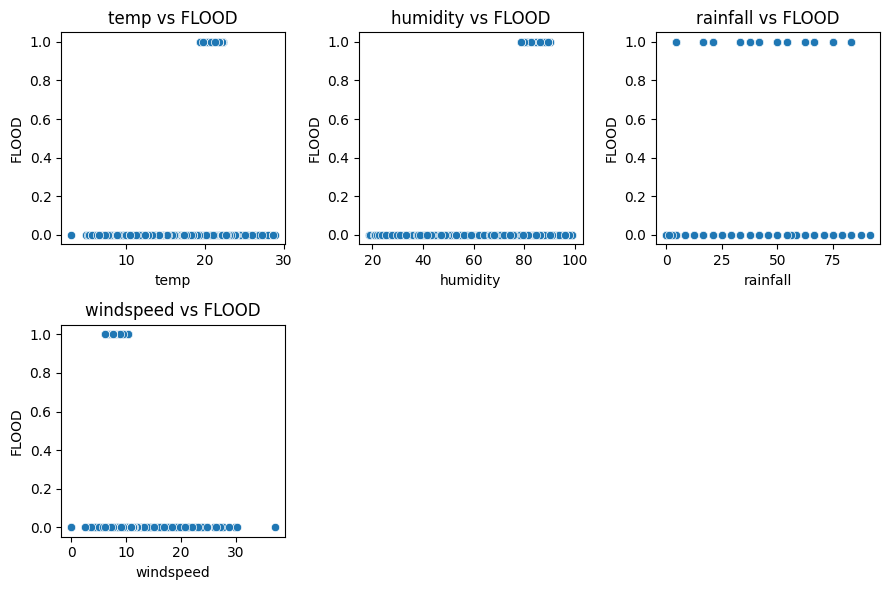

In [30]:
# Define target column
target_column = 'FLOOD'

# Define number of rows and columns for the grid
nrows = (len(weather_data.columns) - 1 + 2) // 3  # 3 graphs per row
ncols = min(len(weather_data.columns) - 1, 3)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, 3 * nrows))

# Flatten axes if necessary
if nrows == 1:
    axes = [axes]

# Plot scatter plot for each feature with the target column
for i, col in enumerate(weather_data.columns):
    if col == target_column:
        continue
    row_index = i // ncols
    col_index = i % ncols
    ax = axes[row_index][col_index]
    sns.scatterplot(x = weather_data[col], y = weather_data[target_column],ax=ax)
    ax.set_title(f'{col} vs {target_column}')
    ax.set_xlabel(col)
    ax.set_ylabel(target_column)

# Remove empty subplots if ncols * nrows > number of features
if nrows * ncols > len(weather_data.columns) - 1:
    for i in range(len(weather_data.columns) - 1, nrows * ncols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show();

### HeatMap Correlation

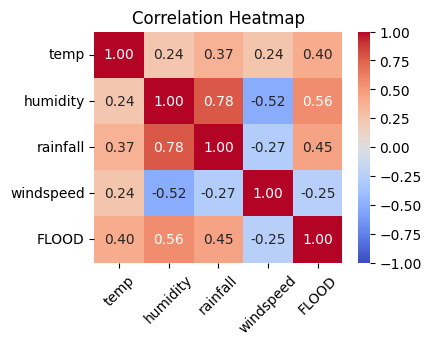

In [31]:

plt.figure(figsize=(4, 3))
sns.heatmap(weather_data.corr(), annot=True,fmt='.2f', cmap='coolwarm', vmax=1, vmin=-1)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.title("Correlation Heatmap")
plt.show()

## Training and Testing Data

In [32]:
X_train , X_test , Y_train , Y_test = train_test_split(X , Y , test_size = 0.2 , stratify = Y , random_state = 1)

In [33]:
print(X.shape , X_train.shape , X_test.shape)

(1103, 4) (882, 4) (221, 4)


In [34]:
print(X_train)
print(Y_train)

      temp  humidity  rainfall  windspeed
1070  21.1      82.6     41.67        6.1
732   20.7      78.6      4.17        7.6
254   20.2      82.8     45.83        6.8
1005  21.7      86.9     62.50        7.2
470   18.8      51.1     16.67       11.2
...    ...       ...       ...        ...
1091  21.7      86.9     62.50        7.2
232   21.8      79.9     20.83        6.1
873   21.8      79.9     20.83        6.1
111   20.8      38.5      0.00       16.2
1042  22.3      85.3     54.17        7.6

[882 rows x 4 columns]
1070    1
732     1
254     0
1005    1
470     0
       ..
1091    1
232     1
873     1
111     0
1042    1
Name: FLOOD, Length: 882, dtype: int64


# Model Training

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:23:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 0.9819
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       138
           1       0.95      1.00      0.98        83

    accuracy                           0.98       221
   macro avg       0.98      0.99      0.98       221
weighted avg       0.98      0.98      0.98       221

[LightGBM] [Info] Number of positive: 332, number of negative: 550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 882, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376417 -> initscore=-0.504783
[LightGBM] [Info] Start training from score -0.504783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LightGBM Accuracy: 0.9864
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       138
           1       0.97      1.00      0.98        83

    accuracy                           0.99       221
   macro avg       0.98      0.99      0.99       221
weighted avg       0.99      0.99      0.99       221


AdaBoost Accuracy: 0.8507
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       138
           1       0.72      1.00      0.83        83

    accuracy                           0.85       221
   macro avg       0.86   

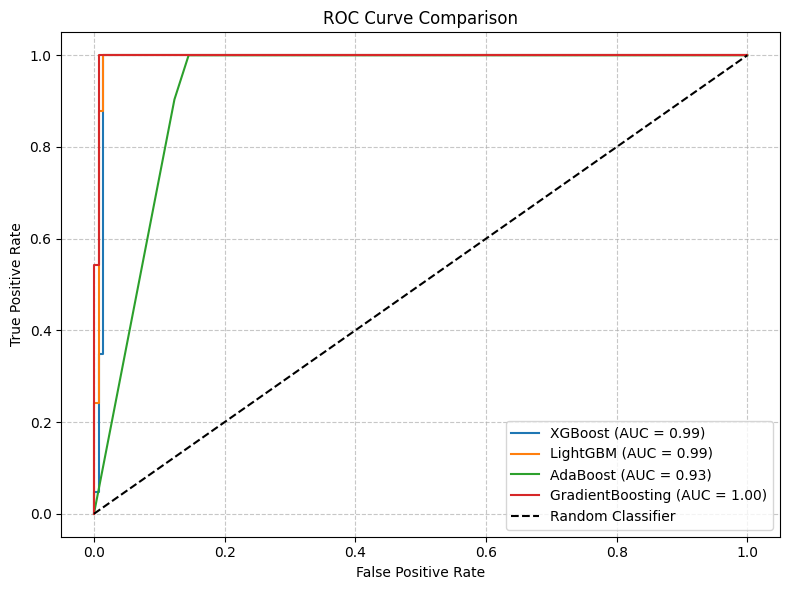


📊 Model Accuracies:
XGBoost: 0.9819
LightGBM: 0.9864
AdaBoost: 0.8507
GradientBoosting: 0.9910


In [35]:
# ✅ Load dataset
df = pd.read_csv("/content/Data_augmented_50.csv")

# ✅ Define features and target
features = ["rainfall", "temp", "windspeed", "humidity"]
X = df[features]
y = df["FLOOD"]

# ✅ Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ✅ Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



# ✅ Define models
models = {
    "XGBoost": XGBClassifier(
        n_estimators=150, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        use_label_encoder=False, eval_metric='logloss', random_state=42
    ),
    "LightGBM": LGBMClassifier(
        n_estimators=150, learning_rate=0.1, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        n_estimators=150, learning_rate=0.1, random_state=42
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=150, learning_rate=0.1, max_depth=5, random_state=42
    )
}

# ✅ Train and evaluate models
results = {}
plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # ROC Curve and AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# ✅ Finalize ROC plot
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# ✅ Optional: Print accuracy comparison
print("\n📊 Model Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")


<Figure size 300x200 with 0 Axes>

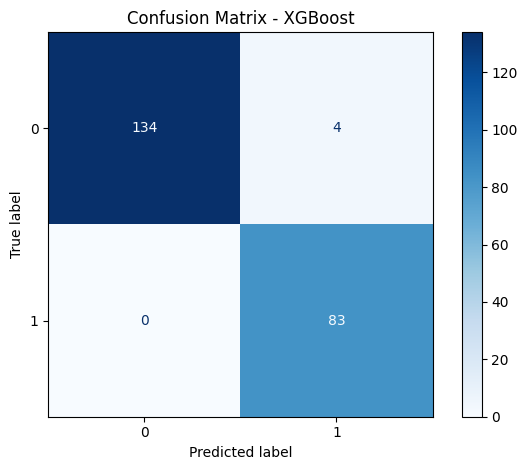

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Figure size 300x200 with 0 Axes>

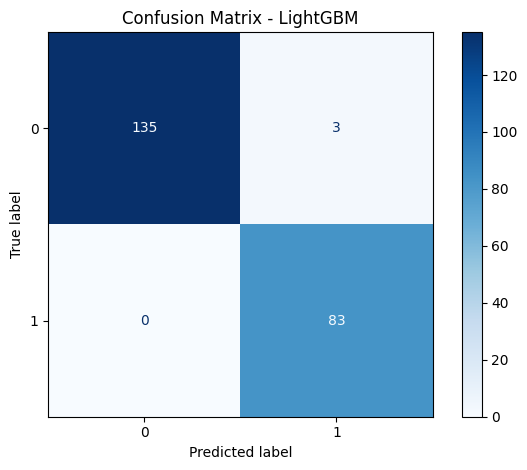

<Figure size 300x200 with 0 Axes>

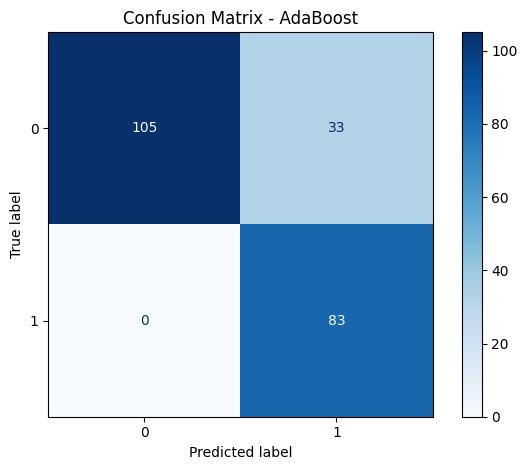

<Figure size 300x200 with 0 Axes>

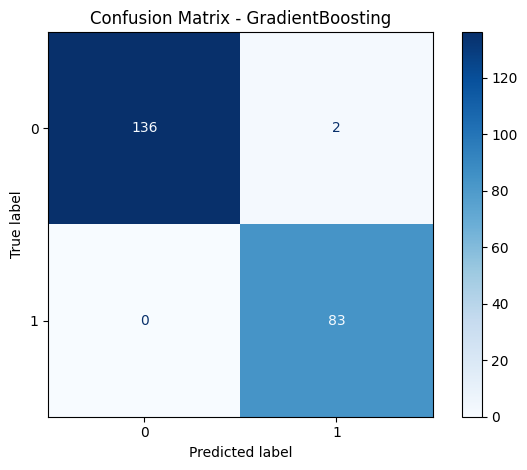

In [36]:
# ✅ Plot confusion matrix for each model
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure(figsize=(3, 2))
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


<ipython-input-37-643225453>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


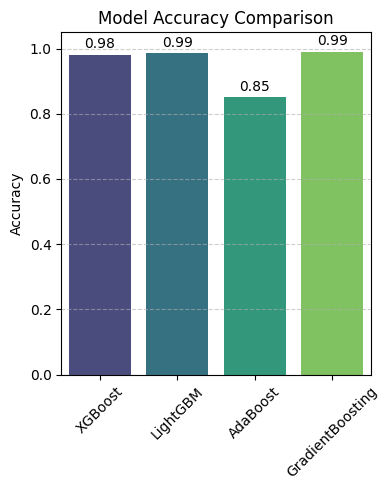

In [37]:
# ✅ Accuracy comparison bar chart with labels
plt.figure(figsize=(4, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')

# Add accuracy labels on top of bars
for i, (model, acc) in enumerate(results.items()):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom', fontsize=10)

plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0, 1.05)  # Ensure bars and labels fit well
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [38]:
project_path = "/content/drive/MyDrive/real_flood_prediction"
os.makedirs(project_path, exist_ok=True)

# Create subfolders
os.makedirs(f"{project_path}/models", exist_ok=True)
os.makedirs(f"{project_path}/static", exist_ok=True)
os.makedirs(f"{project_path}/templates", exist_ok=True)

# Create files
file_names = ["app.py", "requirements.txt", "Data.csv", "ml.py", "templates/index.html", "static/styles.css"]
for file in file_names:
    open(f"{project_path}/{file}", "w").close()

print("Project structure created successfully!")


Project structure created successfully!


In [39]:
# ✅ Set up project paths
project_path = "/content/drive/MyDrive/real_flood_prediction"
model_path = f"{project_path}/models"
os.makedirs(model_path, exist_ok=True)

# ✅ Load dataset
df = pd.read_csv("/content/Data_augmented_50.csv")

# ✅ Define features and target (add more if needed)
features = ["rainfall", "temp", "windspeed", "humidity"]
X = df[features]
y = df["FLOOD"]

# ✅ Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ✅ Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)

# ✅ Evaluate accuracy
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Flood Model Accuracy: {accuracy:.2f}")

# ✅ Save model and scaler
joblib.dump((xgb_model, scaler), f"{model_path}/xgboost_flood_model.pkl")
print(f"✅ Model saved at: {model_path}/xgboost_flood_model.pkl")


✅ XGBoost Flood Model Accuracy: 0.98
✅ Model saved at: /content/drive/MyDrive/real_flood_prediction/models/xgboost_flood_model.pkl


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:23:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [40]:
html_code = """<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8" />
  <title>🌊 Flood Prediction Dashboard</title>
  <link rel="stylesheet" href="{{ url_for('static', filename='styles.css') }}">
  <link rel="stylesheet" href="https://unpkg.com/leaflet/dist/leaflet.css" />
</head>
<body>
  <div class="dashboard-container">
    <header>
      <h1>🌧️ Real-Time Flood Risk Dashboard</h1>
    </header>

    <section class="input-section">
      <form id="cityForm">
        <input type="text" id="cityInput" placeholder="Enter city name" required />
        <button type="submit">Predict</button>
      </form>
    </section>

    <section id="result" class="hidden result">
      <div class="info">
        <h2>🌍 Weather Data</h2>
        <p><strong>Temperature:</strong> <span id="temp"></span> °C</p>
        <p><strong>Humidity:</strong> <span id="humidity"></span>%</p>
        <p><strong>Windspeed:</strong> <span id="windspeed"></span> km/h</p>
        <p><strong>Rainfall:</strong> <span id="rainfall"></span> mm</p>

        <h2>🚨 Flood Prediction</h2>
        <p><strong>Flood Risk:</strong> <span id="risk"></span></p>


        <h2>📲 SMS Alerts</h2>
        <ul id="smsStatus"></ul>
      </div>
      <div id="map"></div>
    </section>
  </div>

  <script src="https://unpkg.com/leaflet/dist/leaflet.js"></script>
  <script src="{{ url_for('static', filename='script.js') }}"></script>
</body>
</html>"""

file_path = os.path.join(project_path, "templates/index.html")
with open(file_path, "w") as f:
    f.write(html_code)

print(f"File saved: {file_path}")



File saved: /content/drive/MyDrive/real_flood_prediction/templates/index.html


In [41]:
css_code = """body {
  margin: 0;
  font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
  background: #eef2f7;
}

.dashboard-container {
  max-width: 1200px;
  margin: auto;
  padding: 30px;
}

header {
  text-align: center;
  margin-bottom: 20px;
}

.input-section {
  display: flex;
  justify-content: center;
  gap: 10px;
  margin-bottom: 20px;
}

input[type="text"] {
  padding: 10px;
  width: 300px;
  border-radius: 8px;
  border: 1px solid #aaa;
  font-size: 16px;
}

button {
  padding: 10px 20px;
  background: #007bff;
  border: none;
  border-radius: 8px;
  color: white;
  cursor: pointer;
  font-size: 16px;
}

button:hover {
  background-color: #0056b3;
}

.result {
  background: white;
  border-radius: 12px;
  padding: 20px;
  display: flex;
  flex-direction: row;
  gap: 20px;
  box-shadow: 0 4px 12px rgba(0,0,0,0.1);
}

.result .info {
  flex: 1;
}

#map {
  height: 400px;
  width: 100%; /* Ensure full width inside flex container */
  flex: 1;
  border-radius: 12px;
  border: 1px solid #ccc;
  background-color: #e0e0e0; /* Optional: for visual debugging */
}

.hidden {
  display: none;
}
"""

file_path = os.path.join(project_path, "static/styles.css")
with open(file_path, "w") as f:
    f.write(css_code)

print(f"File saved: {file_path}")



File saved: /content/drive/MyDrive/real_flood_prediction/static/styles.css


In [42]:
js_code = """document.getElementById('cityForm').addEventListener('submit', async function (e) {
  e.preventDefault();

  const city = document.getElementById('cityInput').value;
  const resultBox = document.getElementById('result');
  const temp = document.getElementById('temp');
  const humidity = document.getElementById('humidity');
  const windspeed = document.getElementById('windspeed');
  const rainfall = document.getElementById('rainfall');
  const risk = document.getElementById('risk');

  const smsStatus = document.getElementById('smsStatus');

  resultBox.classList.add('hidden');
  smsStatus.innerHTML = '';

  try {
    const response = await fetch('/realtime_predict', {
      method: 'POST',
      headers: { 'Content-Type': 'application/json' },
      body: JSON.stringify({ city })
    });

    const data = await response.json();

    if (data.error) {
      alert(data.error);
      return;
    }

    // Populate values
    temp.textContent = data.details.temperature;
    humidity.textContent = data.details.humidity;
    windspeed.textContent = data.details.windspeed;
    rainfall.textContent = data.details.rainfall;
    risk.textContent = data.flood_risk;


    data.sms_status.forEach(msg => {
      const li = document.createElement('li');
      li.textContent = msg;
      smsStatus.appendChild(li);
    });

    resultBox.classList.remove('hidden');

    // Map update
    updateMap(city);

  } catch (err) {
    alert("Error fetching data: " + err.message);
  }
});

// Initialize Leaflet map
var map = L.map('map').setView([20, 0], 2);
L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', {
  attribution: '© OpenStreetMap contributors'
}).addTo(map);

var marker;

function updateMap(location) {
  fetch(`https://nominatim.openstreetmap.org/search?format=json&q=${encodeURIComponent(location)}`)
    .then(res => res.json())
    .then(data => {
      if (data.length === 0) {
        alert("Location not found.");
        return;
      }

      const lat = parseFloat(data[0].lat);
      const lon = parseFloat(data[0].lon);

      map.setView([lat, lon], 5);

      if (marker) map.removeLayer(marker);
      marker = L.marker([lat, lon]).addTo(map);
      marker.bindPopup(`<b>${location}</b><br>Lat: ${lat.toFixed(4)}<br>Lon: ${lon.toFixed(4)}`).openPopup();

      // Fix dimension issue after visibility
      setTimeout(() => {
        map.invalidateSize();
      }, 100);
    })
    .catch(err => {
      console.error(err);
      alert("Error locating city on map.");
    });
}"""

file_path = os.path.join(project_path, "static/script.js")
with open(file_path, "w") as f:
    f.write(js_code)

print(f"File saved: {file_path}")



File saved: /content/drive/MyDrive/real_flood_prediction/static/script.js


In [43]:
!ls /content/drive/MyDrive/real_flood_prediction/templates
!ls /content/drive/MyDrive/real_flood_prediction/static


index.html
script.js  styles.css


In [44]:
with open(".env", "w") as f:
    f.write("""TWILIO_SID=AC8f88c9a9316e1346f3d54602f8194d69
TWILIO_AUTH_TOKEN=646962cdce1000bdaa3b613b529e8104
TWILIO_PHONE=+19786338225
""")


In [ ]:
# Load environment variables
load_dotenv(".env")

# Paths
project_path = "/content/drive/MyDrive/real_flood_prediction"
model_path = os.path.join(project_path, "models/xgboost_flood_model.pkl")

# Load model and scaler
flood_model, scaler = joblib.load(model_path)

# Flask app
app = Flask(__name__, template_folder=os.path.join(project_path, "templates"), static_folder=os.path.join(project_path, "static"))


# Replace this with your actual OpenWeather API key
OPENWEATHER_API_KEY = "6c8f73dd37465df5123114ff403b7391"



# Twilio SMS function
def send_bulk_sms(phone_numbers, message_text):
    account_sid = os.getenv("TWILIO_SID")
    auth_token = os.getenv("TWILIO_AUTH_TOKEN")
    from_number = os.getenv("TWILIO_PHONE")
    client = Client(account_sid, auth_token)

    status = []
    for number in phone_numbers:
        try:
            message = client.messages.create(
                body=message_text,
                from_=from_number,
                to=number
            )
            status.append(f"✅ SMS sent to {number}")
        except Exception as e:
            status.append(f"❌ Failed to send SMS to {number}: {e}")
    return status

# Routes
@app.route("/")
def home():
    return render_template("index.html")

@app.route("/realtime_predict", methods=["POST"])
def realtime_predict():
    try:
        data = request.json
        city = data.get("city")

        # Fetch weather data
        weather_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={OPENWEATHER_API_KEY}&units=metric"
        response = requests.get(weather_url)
        weather = response.json()

        if response.status_code != 200 or "main" not in weather:
            return jsonify({"error": "City not found or weather API failed."})

        temp = weather["main"]["temp"]
        humidity = weather["main"]["humidity"]
        windspeed = weather["wind"]["speed"]
        rainfall = weather.get("rain", {}).get("1h", 0.0)

        features = np.array([[rainfall, temp, windspeed, humidity]])
        scaled_features = scaler.transform(features)

        prediction = flood_model.predict(scaled_features)[0]
        prob = flood_model.predict_proba(scaled_features)[0][1]

        sms_status = []
        if prediction == 1:
            users = ["+917488383672"]  # replace with actual verified numbers
            sms_status = send_bulk_sms(users, "🚨 ALERT: High Flood Risk detected! Take immediate precautions Mr. Md. Shahid Sir.")

        return jsonify({
            "flood_risk": "High" if prediction == 1 else "Low",
            #"risk_percentage": f"{prob * 100:.2f}%",
            "details": {
                "temperature": temp,
                "humidity": humidity,
                "windspeed": round(windspeed, 2),
                "rainfall": rainfall
            },
            "sms_status": sms_status
        })

    except Exception as e:
        return jsonify({"error": str(e)})


# Expose with ngrok
public_url = ngrok.connect(5000)
print(f"🌐 App is live at: {public_url}")

app.run(port=5000)
if __name__ == "__main__":
    app.run(debug=True)


🌐 App is live at: NgrokTunnel: "https://1738-34-134-23-237.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [13/Jun/2025 11:23:33] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2025 11:23:33] "GET /static/styles.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2025 11:23:33] "GET /static/script.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [13/Jun/2025 11:23:34] "GET /favicon.ico HTTP/1.1" 404 -
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [13/Jun/2025 11:23:38] "POST /realtime_predict HTTP/1.1" 200 -


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
